## Section 2: Causal discovery (Découverte des causes)

## Exercice:

![exos](./imgs/d-seperaed_exercise.png)


Trouver toutes les relations d'indépendances

**Résultat:** 

$ X \perp Z_3 $  
$ Z_1 \perp Z_2 $  
$ Z_3 \perp Z_2 $  

Ces chemins précédents sont tous des colliders au minumum ce qui les rend indépendant par définition.

$ M \perp Z_2 | X, Z_1 $  
$ Z_1 \perp Y | M, Z_3, X, Z_2 $  

Ici nous avons des chaines et des colliders, donc pour chaque chaines nous conditionnons la variables intermédiaire (ici X et $Z_1$ pour le premier ) ce qui fait qu'il n'y a plus qu'un collider qui est $ M \to Y \gets Z_2$ marche aussi en ajoutant $ Z_3 $




**Pratique**

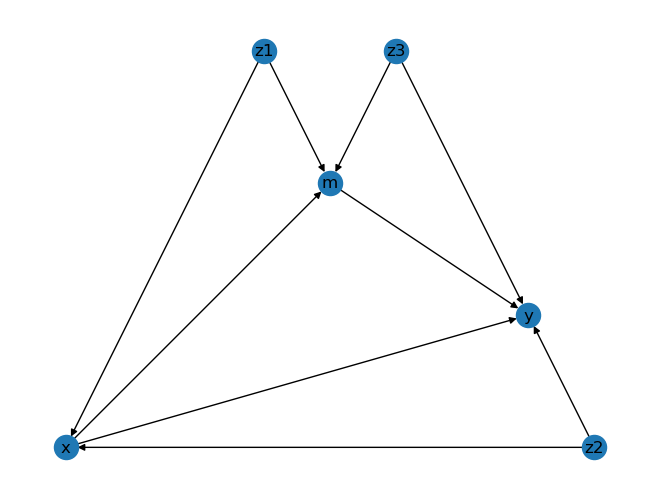

In [3]:
import networkx as nx

g = nx.DiGraph(
    [
        ("x", "y"),
        ("m", "y"),
        ("z2", "y"),
        ("z3", "y"),
        ("x", "m"),
        ("z1", "m"),
        ("z3", "m"),
        ("z1", "x"),
        ("z2", "x")
    ]
)

all_paths = list(nx.all_simple_paths(g, source="x", target="y"))

nx.draw_planar(g, with_labels=True)

In [21]:
import pyAgrum as gum

model = gum.fastBN("y<-m<-z1->x->y<-z3->m<-x<-z2->y")
print(type(model))

model

<class 'pyAgrum.pyAgrum.BayesNet'>


(pyAgrum.BayesNet@0x1e8bbe20) BN{nodes: 6, arcs: 9, domainSize: 64, dim: 31, mem: 496o}

--- 

## Causal discovery

Le but est de trouver toutes les relations d'independance dans les données, et ensuite construire un DAG respectant les condition d'indépendance. 

Comme on a pu le voir il y a différentes implications selon le motif trouvé:
- La chaine ($ X \to Z \to Y $) et la fourchette ($ X \gets Z \to Y $):
    - $ X \not\perp Y $ 
    - $ X \perp Y | Z $
- Le collider ($ X \to Z \gets Y $):
   - $ X \perp Y $
   - $ X \not\perp Y | Z $

De part ces propriétés on peut donc distinguer empiriquement les chaine et fourchette des colliders, et inverse, mais pas les chaines des fourchettes (et inverse) !!

Ce qui fait que pour mener leur distinction il faudra appliquer des connaissances techniques au modèle pour sa compréhension.

### Les hypothèse du causal discovery

- **Le graph est acyclique**: Le modèle sous jacent (généré par les données) est acyclique
- **Suffissance des causes**: Il n'y pas de variable latente/cachés
- **La fidélité causale**: 
    - La D-separation implique certaines relations d'indépendance conditionnelle, mais l'inverse n'est pas nécessairement vrai.
    - La fidélité causale suppose que l'inverse est vrai. (Heinze-Deml et al. 2018) ?????
- **Linéarité et Erreurs Gaussiennes**: Cette hypothèse est intéressante pour les testes d'indépendances conditionnels.



### Fidélité causale (causal faithfulness)

Cela signifie que dans un modèle causal probabiliste, les relations d'indépendance conditionnelle qui existent entre les variables du modèle correspondent aux relations causales qui existent réellement dans le monde.

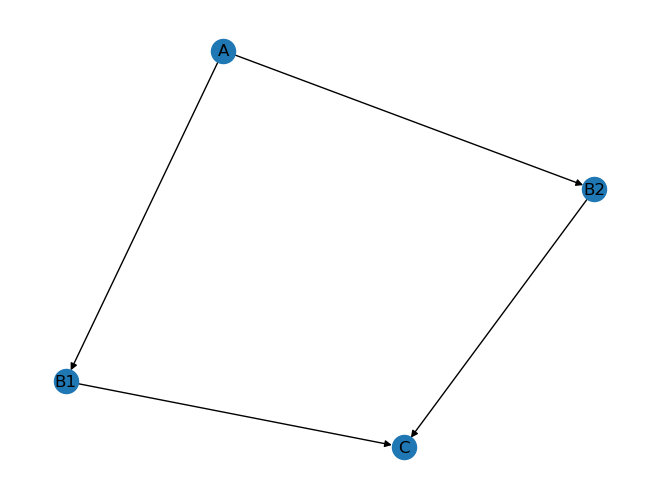

In [3]:
import networkx as nx

g = nx.DiGraph(
    [
        ("A", "B1"),
        ("A", "B2"),
        ("B1", "C"),
        ("B2", "C"),
    ]
)
nx.draw(g, with_labels=True)

Du point de vue de la théorie $ A \to  B1 \to C $ et $ A \to  B2 \to C $ sont deux motifs en "chaines".  
Leurs propriétés est la suivante: $ A \not\perp C $ donc C est dépendant de A. 

Hors du point de vue du monde réel ce n'est pas le cas, car A quand il influence B1 et B2, il peut par exemple **influencer B1 par un coeff c et B2 par un coeff -c**, ainsi l'effet des deux s'ils sont tous deux linéaires **s'annulent** en C.   
Ainsi dans le monde réel, A et C sont indépendants !    

Et dans ce cas on a: 
- $ A \perp C $
- $ A \perp C | B1, B2 $

Par conséquent, il faut exclure ces cas.


> En partique, cela n'est pas courant d'avoir des cas d'annulations parfaites en C rendant l'influence impossible. 

---

## The PC algorithm


En respectant les règles de fidilité causale, de suffisance causale et d'acyclicité, nous pouvons appliqué le PC algorithme. (Crée par Peter Spirtes et Clark Glymour en 2000)

Les trois étapes de l'algorithme:

### 1. Determiner les squelettes du graphe (donc un graph non dirigé)

Algorithm: 
```
1. Le graph de départ est un graph complet non dirigé. 
2. Pour k = 0, 1, 2, ..., et pour deux nœuds adjacents i et j,
tester l'indépendance conditionnelle de X_i et X_j sachant X_S pour tout S ⊆ adj(i)\{j} avec |S| = k et
pour tout S ⊆ adj(j){i} avec |S| = k.        
3. Supprimer tous les edges si leur indépendance conditionnel est trouvé avec niveau de confiance à \alpha
4. Stocker l'ensemble séparateur S (?????)
```
-># TODO: Comprendre ce qu'est l'ensemble séparateur...


### 2. Determiner la v-structure (on determine la structure en fonction de la d-separation)


Algorithm:
```
1. Récupérer tous les edges
2. Considérer tous les triplets non protégés (?), c'est-à-dire i --- j --- k où i et k ne sont pas adjacents
3. Déterminer si la triplette doit etre orienté comme une structure en V (un motif de collider) via les critère de d-separation => X -> Z <- Y où X et Y sont indépendant mais dépendant conditionnement à Z.
```
### 3. Determiner l'orientation des edges (sur la base des regles de consistance)


Algorithm: 
        ?

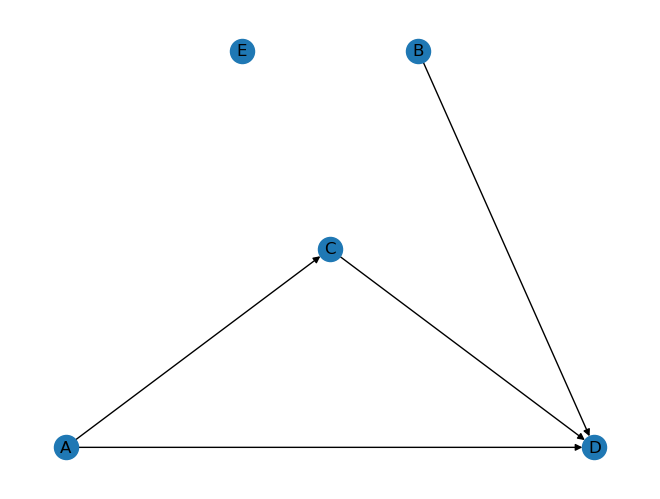

In [21]:
import networkx as nx

g = nx.DiGraph([
    ("A", "D"),
    ("A", "C"),
    ("C", "D"),
    ("B", "D")
    ]
)
g.add_node("E")
nx.draw_planar(g, with_labels=True)

In [1]:
import numpy as np
import pandas as pd

normal_law_1000 = lambda: pd.Series(np.random.normal(size=1000))

a = normal_law_1000()
b = normal_law_1000()
c = a + normal_law_1000()
d = a + c + b + normal_law_1000()
e = normal_law_1000()

df = pd.concat([a, b, c, d, e], axis=1)
df.head(3)

,0,1,2,3,4
0,-1.808674,-0.484674,-0.686577,-3.661644,0.399457
1,1.957985,1.100144,1.130951,4.585249,0.932656
2,0.311970,-1.160415,0.919364,2.799934,-0.312311


In [2]:
df.corr()

,0,1,2,3,4
0,1.000000,-0.003613,0.682284,0.741901,0.015286
1,-0.003613,1.000000,0.029157,0.404858,0.016953
2,0.682284,0.029157,1.000000,0.792538,0.011950
3,0.741901,0.404858,0.792538,1.000000,0.022935
4,0.015286,0.016953,0.011950,0.022935,1.000000


#### Phase 1: Découverte du squelette du graphe

In [57]:
%reload_ext autoreload
%autoreload 2

from utils import gauss_ci_test, skeleton, get_triplet_with_permutations, get_all_oriented_edges, get_oriented_edges

# Phase 1 de l'algorithme PC 

list_node = list(range(5))

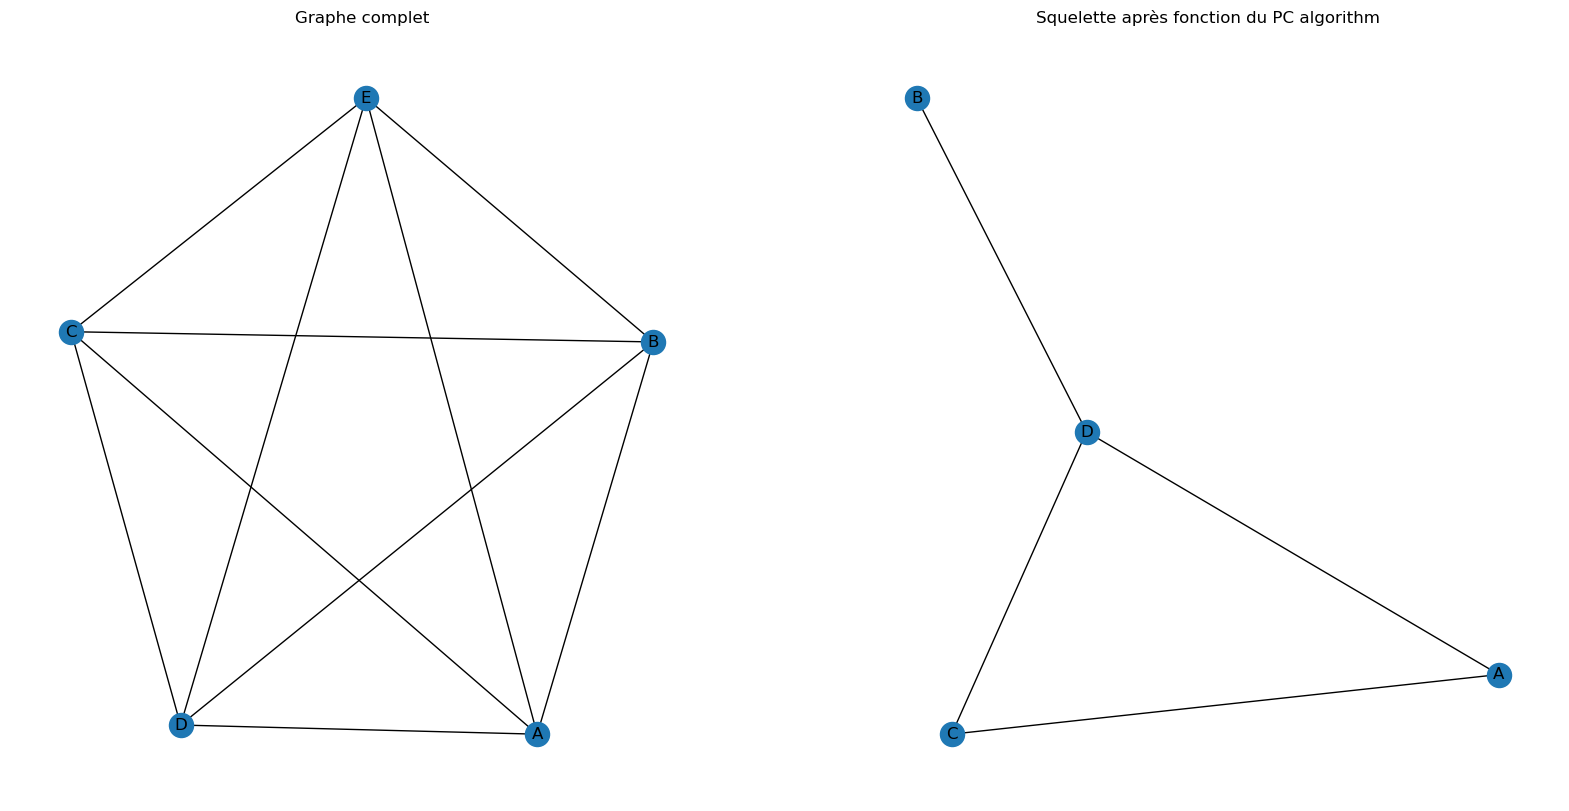

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

nodes_name = ["A", "B", "C", "D", "E"]

g = nx.Graph([
    (n1, n2)
    for n1 in nodes_name
    for n2 in nodes_name
    if n1 != n2
    ]
)
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title("Graphe complet")
nx.draw(g, with_labels=True)

nodes_name = ["A", "B", "C", "D", "E"]
node_list = skeleton(list_node, gauss_ci_test, df)

validate_node = [n_l[:2] for n_l in node_list if n_l[2]]

g = nx.Graph([
    (n1, n2)
    for idx1, n1 in enumerate(nodes_name)
    for idx2, n2 in enumerate(nodes_name)
    if n1 != n2 and [idx1, idx2] in validate_node
    ]
)
plt.subplot(1, 2, 2)
plt.title("Squelette après fonction du PC algorithm")
nx.draw(g, with_labels=True)

#### Phase 2: trouver la v-struture dans les triplettes

In [38]:
triplets = get_triplet_with_permutations(g)

traductor = {k:i for i, k in enumerate(["A", "B", "C", "D", "E"])}
reverse_trad = {i:k for k, i in traductor.items()}

triplets_num = [[traductor[n] for n in t] for t in triplets]

In [39]:
def is_a_collider_triplet(triplet, df, test=gauss_ci_test, alpha=0.05):
    X, Z, Y = triplet
    data = df.to_numpy()

    # En utilisant la proriété du collider qu'il est conditionnellement idpt,
    # on trouve un collider.
    cond_idpt_test_pval, _ = gauss_ci_test(X, Y, [Z], data=data)
    idpt_test_pval, _ = gauss_ci_test(X, Y, None, data=data)
    is_collider = False

    if (idpt_test_pval > alpha) and (cond_idpt_test_pval < alpha):
        is_collider = True

    return is_collider

is_collider = is_a_collider_triplet(triplet=triplets_num[2], df=df, test=gauss_ci_test)

In [40]:
all_colliders = [t for t in triplets_num if is_a_collider_triplet(triplet=t, df=df, test=gauss_ci_test)]
all_not_colliders = [t for t in triplets_num if not is_a_collider_triplet(triplet=t, df=df, test=gauss_ci_test)]


all_edges = set(get_oriented_edges(all_colliders) + get_all_oriented_edges(all_not_colliders))

In [54]:
edges_collider = get_oriented_edges(all_colliders)
edge_not_collider = [e for e in get_all_oriented_edges(all_not_colliders) if (e[1], e[0]) not in edges_collider and e not in edges_collider]
all_edges = set(edges_collider + edge_not_collider )

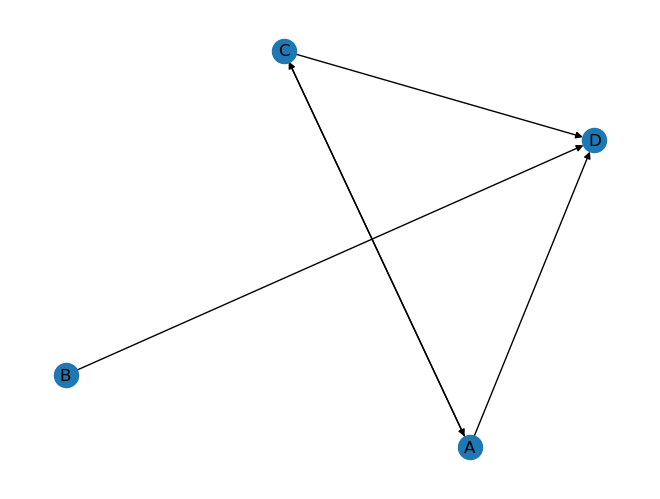

In [56]:
all_edges_know = [[reverse_trad[v] for v in e] for e in all_edges]
g1 = nx.DiGraph(all_edges_know)

nx.draw(g1, with_labels=True)

On obtient un PDAG soit un partial directed acyclic graph..